In [16]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKX4ZIXWV9HTG4JDDTMQ', 'BNb47rETbt7rJwuJxjJb42b3QtIr52TyhESHfogr', api_version='v2')

# Set the ticker symbol and time frame ( XLK - Info Tech )
ticker = "XLF"
timeframe = "1Day"

# Set the start and end dates for the data

start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df['target_close']=df['close']
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [17]:
for index, row in df.iterrows():
    if row["target_close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["target_close"] < 0:
        df.loc[index,"Signal"] = 0.0

# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["target_close"].shift(-1)
#df['RR']=df["RewardRisk"]


df

,close,HH21,LL21,50Pct,61Pct,50R,61R,Mid,RewardRisk,CPctile,OPctile,RangeT,target_close,Signal,FutureSlope
timestamp,,,,,,,,,,,,,,,
2015-12-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278302,0.031746,0.698413,NaN,NaN,0.0,-0.006088
2015-12-02 05:00:00+00:00,-0.006088,NaN,NaN,NaN,NaN,NaN,NaN,0.002036,0.715190,0.889908,0.302752,NaN,-0.006088,0.0,-0.013158
2015-12-03 05:00:00+00:00,-0.013158,NaN,NaN,NaN,NaN,NaN,NaN,-0.011006,-28.625000,0.796117,0.126214,NaN,-0.013158,1.0,0.024598
2015-12-04 05:00:00+00:00,0.024598,NaN,NaN,NaN,NaN,NaN,NaN,0.006563,-0.010336,0.067873,0.918552,NaN,0.024598,0.0,-0.004936
2015-12-07 05:00:00+00:00,-0.004936,NaN,NaN,NaN,NaN,NaN,NaN,0.005814,0.030928,0.497247,0.090256,NaN,-0.004936,0.0,-0.002480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 05:00:00+00:00,0.001044,139.3325,122.355,8.48875,6.536338,14.678251,19.062663,-0.004797,0.129909,0.058468,0.555447,-0.673813,0.001044,0.0,-0.009470
2022-12-27 05:00:00+00:00,-0.009470,139.3325,122.355,8.48875,6.536338,14.539243,18.882134,-0.001243,0.755869,0.570588,0.129412,-0.919719,-0.009470,0.0,-0.016124
2022-12-28 05:00:00+00:00,-0.016124,139.3325,121.290,9.02125,6.946363,13.460441,17.481092,-0.006152,NaN,0.953020,0.385906,0.159864,-0.016124,1.0,0.026188


In [18]:
df.tail(100)

,close,HH21,LL21,50Pct,61Pct,50R,61R,Mid,RewardRisk,CPctile,OPctile,RangeT,target_close,Signal,FutureSlope
timestamp,,,,,,,,,,,,,,,
2022-08-10 04:00:00+00:00,0.027302,148.3700,126.230,11.07000,8.523900,13.392051,17.392273,0.022607,4.152941,0.066298,0.348066,-1.338754,0.027302,0.0,-0.003912
2022-08-11 04:00:00+00:00,-0.003912,150.0500,126.230,11.91000,9.170700,12.398825,16.102370,0.008544,-8.215686,0.898113,0.328302,-0.317243,-0.003912,1.0,0.019909
2022-08-12 04:00:00+00:00,0.019909,150.6200,130.600,10.01000,7.707700,15.045954,19.540200,0.004539,0.771605,0.004098,0.811475,-0.536409,0.019909,1.0,0.006308
2022-08-15 04:00:00+00:00,0.006308,151.7800,130.600,10.59000,8.154300,14.311615,18.586513,0.009438,0.116732,0.113402,0.912371,-1.123391,0.006308,0.0,-0.002705
2022-08-16 04:00:00+00:00,-0.002705,151.8600,131.760,10.05000,7.738500,15.039801,19.532209,-0.000066,0.088976,0.334906,0.466981,-0.844630,-0.002705,0.0,-0.007145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 05:00:00+00:00,0.001044,139.3325,122.355,8.48875,6.536338,14.678251,19.062663,-0.004797,0.129909,0.058468,0.555447,-0.673813,0.001044,0.0,-0.009470
2022-12-27 05:00:00+00:00,-0.009470,139.3325,122.355,8.48875,6.536338,14.539243,18.882134,-0.001243,0.755869,0.570588,0.129412,-0.919719,-0.009470,0.0,-0.016124
2022-12-28 05:00:00+00:00,-0.016124,139.3325,121.290,9.02125,6.946363,13.460441,17.481092,-0.006152,NaN,0.953020,0.385906,0.159864,-0.016124,1.0,0.026188


In [19]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'target_close', 'Signal',
       'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

,FutureSlope,close
FutureSlope,1.000000,-0.188706
close,-0.188706,1.000000


:Scatter   [HH21]   (FutureSlope)

,FutureSlope,HH21
FutureSlope,1.000000,-0.026926
HH21,-0.026926,1.000000


:Scatter   [LL21]   (FutureSlope)

,FutureSlope,LL21
FutureSlope,1.000000,-0.027878
LL21,-0.027878,1.000000


:Scatter   [50Pct]   (FutureSlope)

,FutureSlope,50Pct
FutureSlope,1.000000,-0.014935
50Pct,-0.014935,1.000000


:Scatter   [61Pct]   (FutureSlope)

,FutureSlope,61Pct
FutureSlope,1.000000,-0.014935
61Pct,-0.014935,1.000000


:Scatter   [50R]   (FutureSlope)

,FutureSlope,50R
FutureSlope,1.000000,-0.007246
50R,-0.007246,1.000000


:Scatter   [61R]   (FutureSlope)

,FutureSlope,61R
FutureSlope,1.000000,-0.007246
61R,-0.007246,1.000000


:Scatter   [Mid]   (FutureSlope)

,FutureSlope,Mid
FutureSlope,1.00000,-0.12227
Mid,-0.12227,1.00000


:Scatter   [RewardRisk]   (FutureSlope)

,FutureSlope,RewardRisk
FutureSlope,1.000000,-0.062073
RewardRisk,-0.062073,1.000000


:Scatter   [CPctile]   (FutureSlope)

,FutureSlope,CPctile
FutureSlope,1.000000,0.099796
CPctile,0.099796,1.000000


:Scatter   [OPctile]   (FutureSlope)

,FutureSlope,OPctile
FutureSlope,1.000000,-0.019406
OPctile,-0.019406,1.000000


:Scatter   [RangeT]   (FutureSlope)

,FutureSlope,RangeT
FutureSlope,1.000000,-0.037282
RangeT,-0.037282,1.000000


:Scatter   [target_close]   (FutureSlope)

,FutureSlope,target_close
FutureSlope,1.000000,-0.188706
target_close,-0.188706,1.000000


:Scatter   [Signal]   (FutureSlope)

,FutureSlope,Signal
FutureSlope,1.000000,0.670025
Signal,0.670025,1.000000


:Scatter   [FutureSlope]   (FutureSlope)

,FutureSlope,FutureSlope
FutureSlope,1.0,1.0
FutureSlope,1.0,1.0


In [20]:
df=df.dropna()

y = df['Signal']

# Review the value count
y.value_counts()

1.0    978
0.0    774
Name: Signal, dtype: int64

In [21]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=60)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2016-01-13 05:00:00+00:00
2021-01-13 05:00:00+00:00


,50Pct,61Pct,RangeT,OPctile,CPctile
timestamp,,,,,
2016-01-13 05:00:00+00:00,2.2150,1.705550,2.885637,0.000000,0.952381
2016-01-14 05:00:00+00:00,2.3325,1.796025,2.228032,0.652015,0.227106
2016-01-15 05:00:00+00:00,2.6150,2.013550,0.575669,0.651163,0.441860
2016-01-19 05:00:00+00:00,2.6150,2.013550,0.541472,0.083333,0.583333
2016-01-20 05:00:00+00:00,2.9485,2.270345,2.277157,0.523378,0.272156


,50Pct,61Pct,RangeT,OPctile,CPctile
timestamp,,,,,
2021-01-07 05:00:00+00:00,4.25,3.2725,0.961662,0.979920,0.100402
2021-01-08 05:00:00+00:00,4.25,3.2725,0.178610,0.300546,0.191257
2021-01-11 05:00:00+00:00,4.25,3.2725,-0.300479,0.760274,0.630137
2021-01-12 05:00:00+00:00,4.25,3.2725,0.155649,0.091398,0.338710
2021-01-13 05:00:00+00:00,3.40,2.6180,-0.516560,0.807692,0.307692


In [22]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.57      0.14      0.23       250
         1.0       0.50      0.89      0.64       242

    accuracy                           0.51       492
   macro avg       0.54      0.52      0.43       492
weighted avg       0.54      0.51      0.43       492



<AxesSubplot:xlabel='timestamp'>

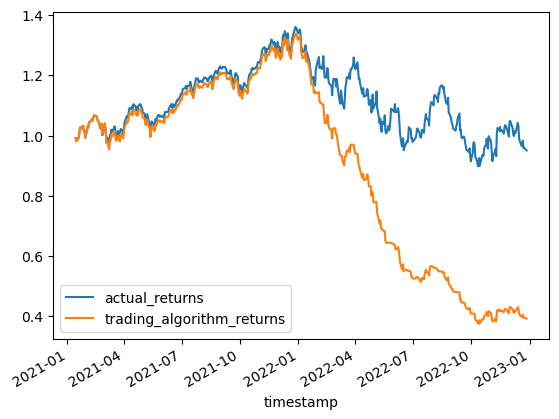

In [23]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["close"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()